# Lectura del dataset

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

from sklearn.svm import SVC

In [10]:
df_train = pd.read_csv('data/diabetes_prediction_dataset_train-labeled.csv')
df_test = pd.read_csv('data/diabetes_prediction_dataset_test.csv')

In [11]:
X = df_train.drop(columns=['patient', 'diabetes'])
y = df_train['diabetes']
x_train, x_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state = 8)

In [12]:
x_test = df_test.drop(columns=['patient', 'diabetes'])
y_test = df_test['diabetes']
PatientId_test = df_test['patient']

# Preprocesamiento

In [13]:
pp_pipe = joblib.load('preproc_pipeline.pkl')

In [14]:
# Fiteo el pipeline
x_train_transformed = pp_pipe.fit_transform(x_train)
x_val_transformed = pp_pipe.transform(x_val)
x_test_transformed = pp_pipe.transform(x_test)

In [15]:
cat_cols = ['gender', 'smoking_history']
num_cols = [x for x in df_train.columns if x not in cat_cols and x not in ['patient', 'diabetes']]
# En las columnas numéricas quitamos la columna "patient" que contiene el id de los pacientes y "diabetes" que es la variable target

In [16]:
# Para obtener el nombre de las columnas creadas a partir del OneHotEncoder es necesario acceder al mismo de esta manera:
pp_pipe.transformers_[0][1]

OneHotEncoder(drop='first')

In [17]:
# Con el método get_features_names_out se puede obtener el nombre de las columnas creadas
pp_pipe.transformers_[0][1].get_feature_names_out()

array(['gender_Male', 'gender_Other', 'smoking_history_current',
       'smoking_history_ever', 'smoking_history_former',
       'smoking_history_never', 'smoking_history_not current'],
      dtype=object)

In [18]:
cols = pp_pipe.transformers_[0][1].get_feature_names_out().tolist() + num_cols
x_test_transformed = pd.DataFrame(x_test_transformed, columns=cols)

# SVM

## Prueba inicial

Se utiliza el clasificador con todos sus valores por defecto.

In [19]:
name = 'SVM'
svm = SVC(random_state = 10, verbose = True)
print(svm)
svm.fit(x_train_transformed, y_train)

train_predictions = svm.predict(x_train_transformed)
accuracy = accuracy_score(y_train, train_predictions)
print(f"\n\nAccuracy train {name}: %.3f%%" % (accuracy * 100.0))

val_predictions = svm.predict(x_val_transformed)
accuracy = accuracy_score(y_val, val_predictions)
print(f"Accuracy val {name}: %.3f%%" % (accuracy * 100.0))

SVC(random_state=10, verbose=True)
[LibSVM]

.

## Hiperparámetros - Round 1

### Ajuste de hiperparámetros - Round 1

In [ ]:
params = {'C' : [1E-3, 1E-2, 1E-1, 1, 1E1, 1E2],
          'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'], 
          'class_weight' : [None, 'balanced'], 
          'random_state' : [10]}

In [ ]:
# grid = GridSearchCV(SVC(), params, verbose=10)
# grid.fit(x_train_transformed,y_train)
# grid.best_params_

In [ ]:
grid_bal = pd.read_csv('svm/svm_gridsearch_balanced.csv', sep=',')
grid_notbal = pd.read_csv('svm/svm_gridsearch_not-balanced.csv', sep=',')

Vemos que:
* El Kernel sigmoideo es el peor en ambos casos.
* El caso no balanceado tiene mejores scores y tiempos que el caso balanceado.

Centrándonos en los casos no balanceados:
* El que tiene el mejor score es con Kernel=poly cuando C=100 con un score de 0.9684. Sin embargo, para el caso con Kernel=poly cuando C=10 el score es de 0.9668, *i.e.* hay una diferencia menor al 0.2% entre ambos scores. El mayor impacto se tiene en el tiempo de la corrida: tarda bastante menos para C=10.
* Tomando ahora C=10, vemos que la diferencia entre poly y rbf no es significativa, pero sí se diferencian por sus tiempos: rbf es más rápido.

Se toma como parámetros óptimos entonces:
* C=10
* kernel='rbf' (default)
* class_weight=None (default)

(No olvidar random_state=10)

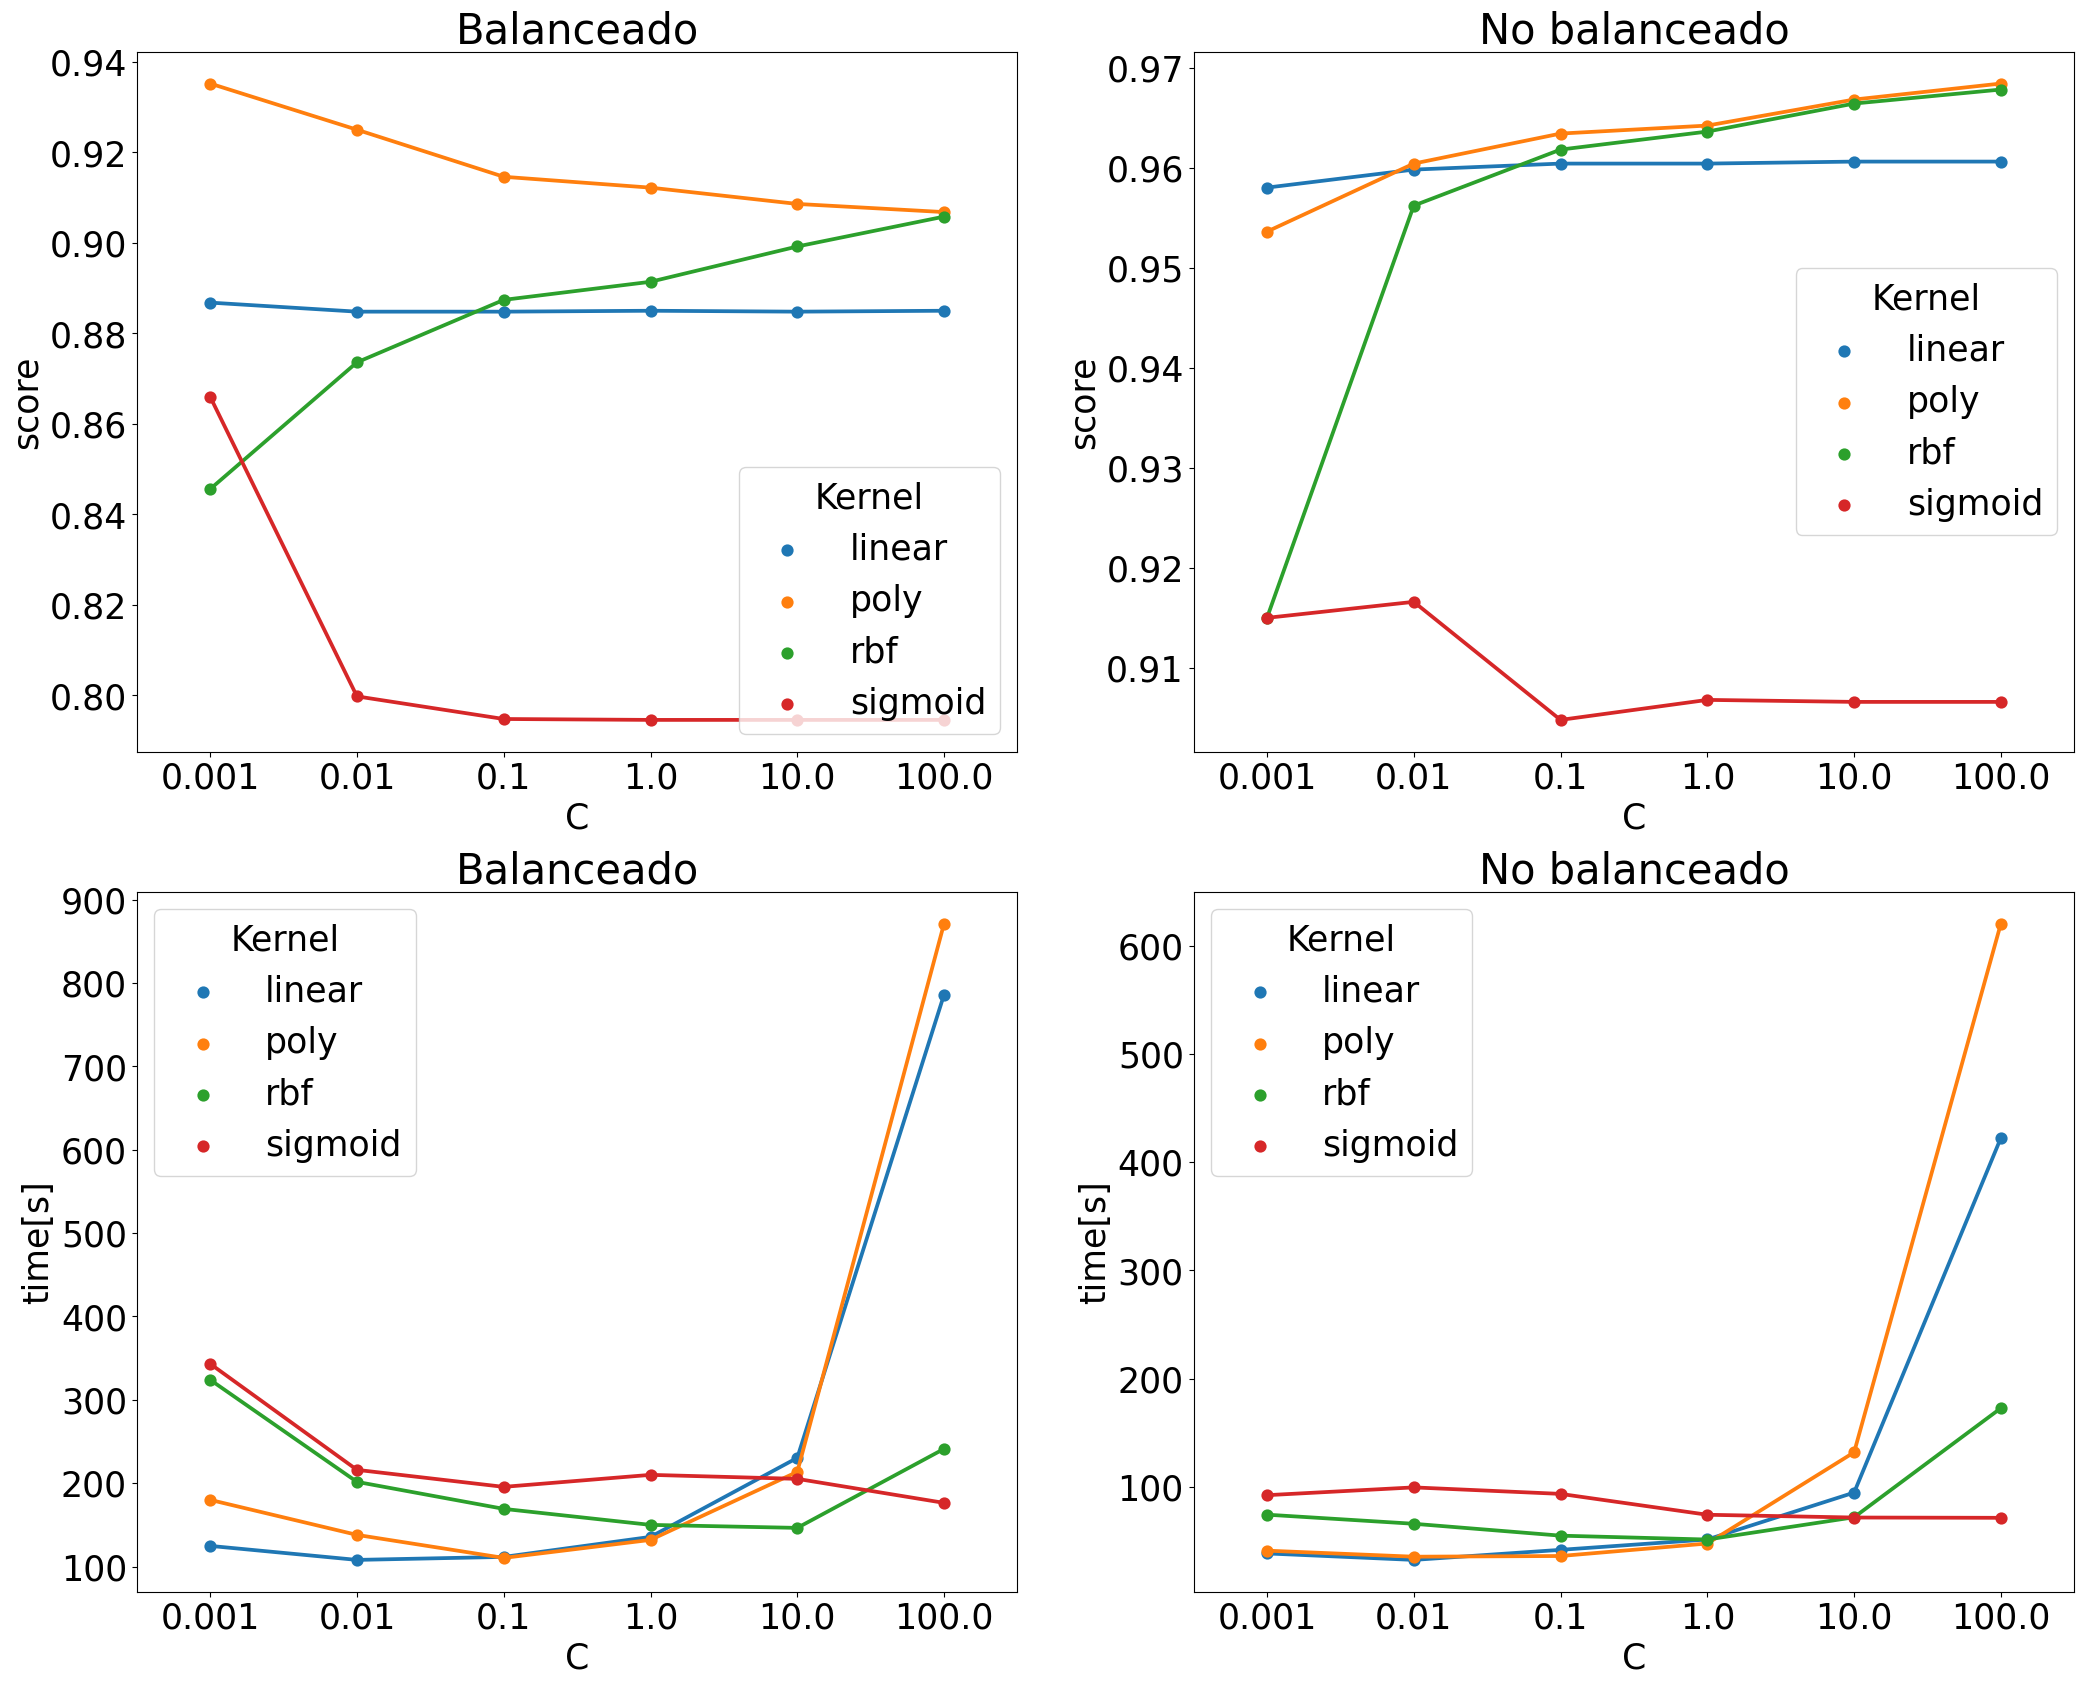

In [ ]:
plt.rcParams["font.size"] = 25

fig, axs = plt.subplots(2, 2, figsize=(25, 20))

sns.pointplot(grid_bal, x='C', y='score', hue='Kernel', ax=axs[0, 0], markers='o')
axs[0, 0].set_title('Balanceado')

sns.pointplot(grid_notbal, x='C', y='score', hue='Kernel', ax=axs[0, 1], markers='o')
axs[0, 1].set_title('No balanceado')

sns.pointplot(grid_bal, x='C', y='time[s]', hue='Kernel', ax=axs[1, 0], markers='o')
axs[1, 0].set_title('Balanceado')

sns.pointplot(grid_notbal, x='C', y='time[s]', hue='Kernel', ax=axs[1, 1], markers='o')
axs[1, 1].set_title('No balanceado')

plt.show()


### Aplicando parámetros óptimos - Round 1

In [ ]:
# popt = grid.best_params_
popt = {'C':10, 'random_state':10}

In [ ]:
svm = SVC(**popt)
print(svm)
svm.fit(x_train_transformed, y_train)

train_predictions = svm.predict(x_train_transformed)
accuracy = accuracy_score(y_train, train_predictions)
print(f"\n\nAccuracy train {name}: %.3f%%" % (accuracy * 100.0))

val_predictions = svm.predict(x_val_transformed)
accuracy = accuracy_score(y_val, val_predictions)
print(f"Accuracy val {name}: %.3f%%" % (accuracy * 100.0))

SVC(C=10, random_state=10)


Accuracy train SVM: 96.891%
Accuracy val SVM: 96.889%


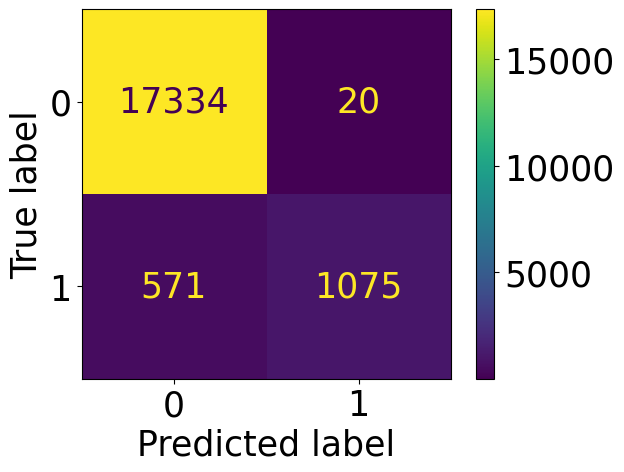

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_val, val_predictions)
plt.show()

In [ ]:
print(classification_report(y_val,svm.predict(x_val_transformed)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17354
           1       0.98      0.65      0.78      1646

    accuracy                           0.97     19000
   macro avg       0.97      0.83      0.88     19000
weighted avg       0.97      0.97      0.97     19000



### Cross validation - Round 1

In [ ]:
FOLDS=5
cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=10)

x_train2 = np.array(x_train_transformed)
y_train2 = np.array(y_train)

svm = SVC(**popt)
print(svm)
avg_accuracy = 0
for fold, (train_idx, val_idx) in enumerate(cv.split(x_train2, y_train2)):
    xi, yi = x_train2[train_idx], y_train2[train_idx]
    x_valid, y_valid = x_train2[val_idx], y_train2[val_idx]
    svm = svm.fit(xi, yi)

    val_predictions = svm.predict(x_valid)
    accuracy = accuracy_score(y_valid, val_predictions)
    avg_accuracy +=accuracy
    print(f"Precisión val fold {fold}: {accuracy * 100.0 :.2f}" % ())

avg_accuracy /= FOLDS
print(f'\n\nAvg. accuracy = {avg_accuracy * 100}')

SVC(C=10, random_state=10)
Precisión val fold 0: 96.82
Precisión val fold 1: 96.68
Precisión val fold 2: 96.58
Precisión val fold 3: 96.55
Precisión val fold 4: 96.62


Avg. accuracy = 96.65131578947367


Al final no resultó tanto mejor. Vamos a barrer parámetros para poly.

## Evaluación y guardado - Round 1 - C = 10 ; Kernel = 'rbf'

In [ ]:
test_pred = np.int64(svm.predict(x_test_transformed))

/home/cheva/.local/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [ ]:
submission = pd.DataFrame(list(zip(PatientId_test, test_pred)), columns=["patient", "diabetes"])
submission.to_csv("results/svm_rbf.csv", header=True, index=False)

## Hiperparámetros - Round 2

### Ajuste de hiperparámetros - Round 2

In [ ]:
params = {'C' : [1E1, 1E2],
          'kernel' : ['poly'], 
          'degree' : [2, 3, 4],
          'random_state' : [10]}

In [ ]:
# grid = GridSearchCV(SVC(), params, verbose=10)
# grid.fit(x_train_transformed,y_train)
# grid.best_params_

In [ ]:
grid_poly = pd.read_csv('svm/svm_gridsearch_poly.csv', sep=',')

Al final lo mejor de lo mejor es con
* C=100
* kernel='poly'
* degree=3 (default)
* class_weight=None (default)

(No olvidar random_state=10)

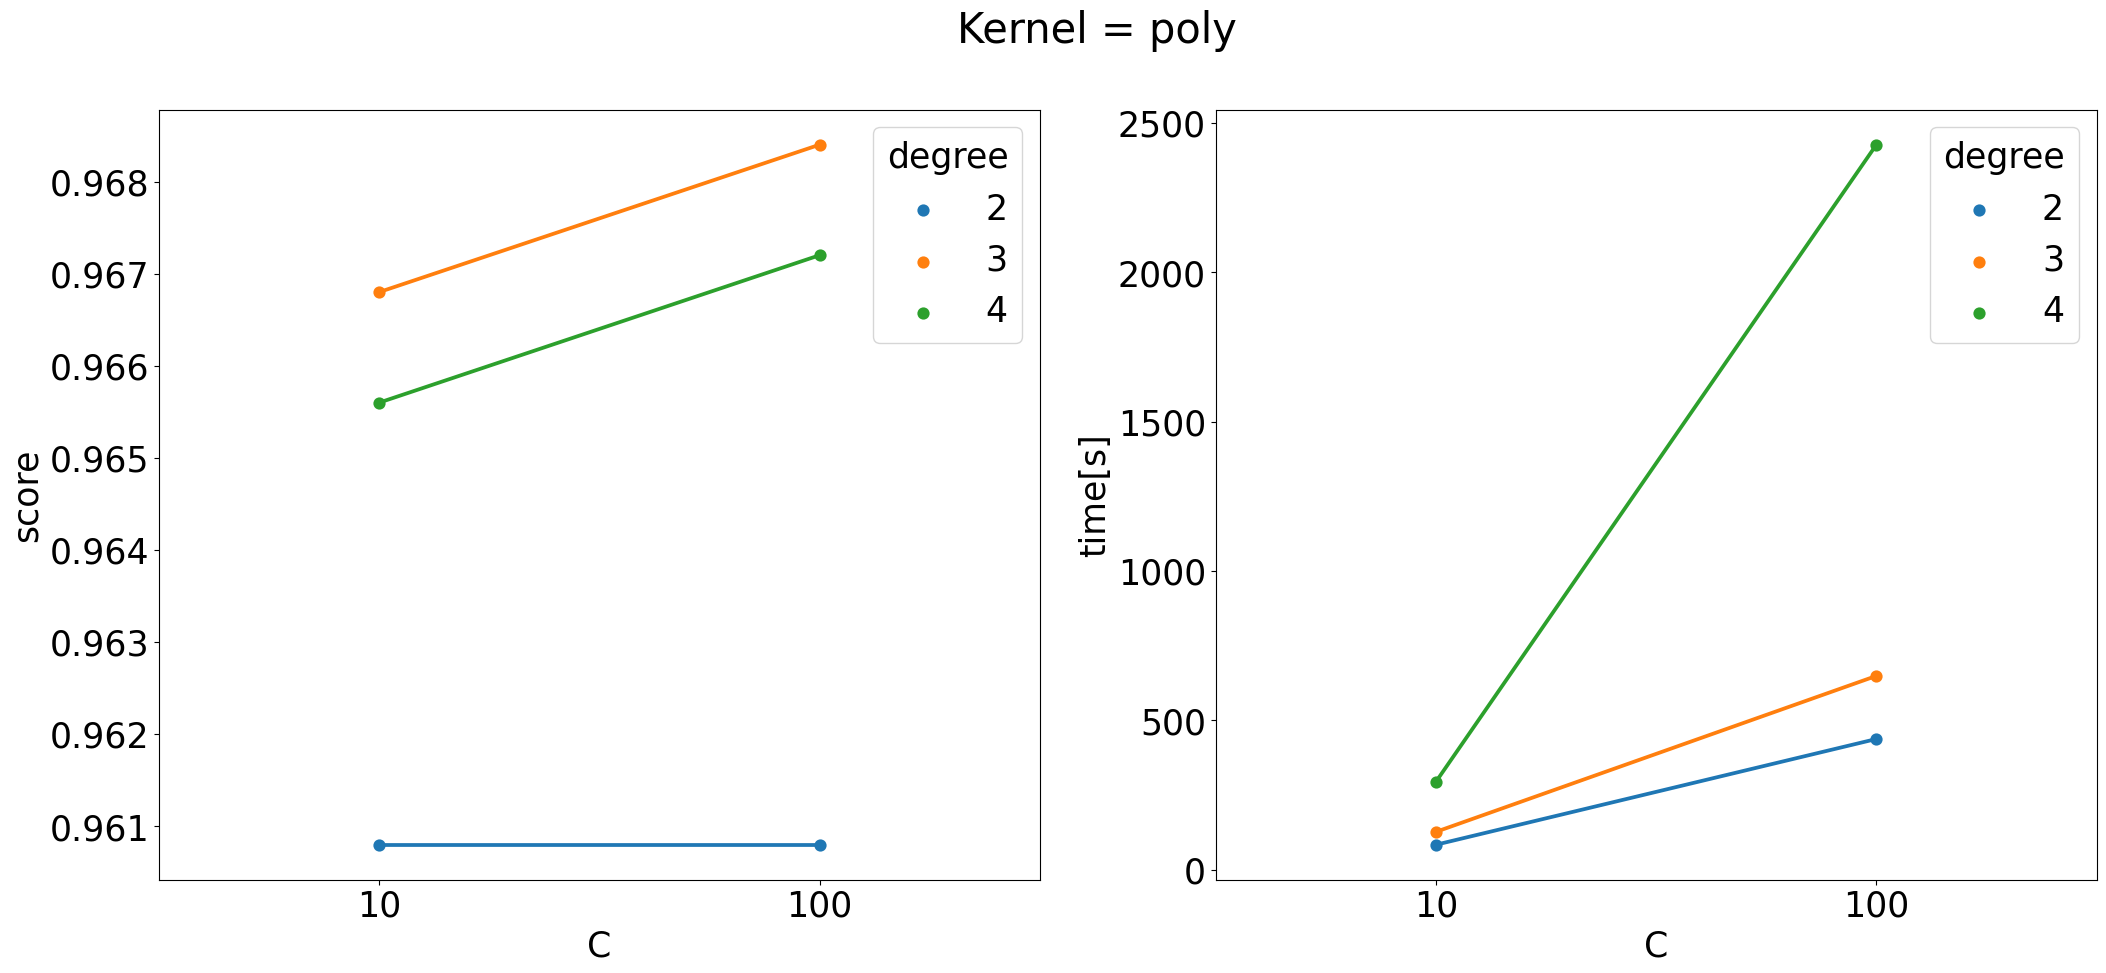

In [ ]:
plt.rcParams["font.size"] = 25

fig, axs = plt.subplots(1, 2, figsize=(25, 10))
fig.suptitle('Kernel = poly')

sns.pointplot(grid_poly, x='C', y='score', hue='degree', ax=axs[0], markers='o')

sns.pointplot(grid_poly, x='C', y='time[s]', hue='degree', ax=axs[1], markers='o')

plt.show()


### Aplicando parámetros óptimos - Round 2

In [ ]:
# popt = grid.best_params_
popt = {'C':100, 'kernel':'poly', 'random_state':10}

In [ ]:
svm = SVC(**popt)
print(svm)
svm.fit(x_train_transformed, y_train)

train_predictions = svm.predict(x_train_transformed)
accuracy = accuracy_score(y_train, train_predictions)
print(f"\n\nAccuracy train {name}: %.3f%%" % (accuracy * 100.0))

val_predictions = svm.predict(x_val_transformed)
accuracy = accuracy_score(y_val, val_predictions)
print(f"Accuracy val {name}: %.3f%%" % (accuracy * 100.0))

SVC(C=100.0, kernel='poly', random_state=10)


Accuracy train SVM: 96.904%
Accuracy val SVM: 97.026%


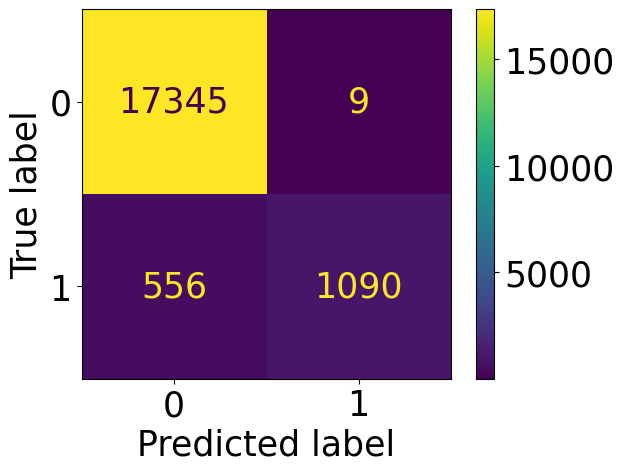

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_val, val_predictions)
plt.show()

In [ ]:
print(classification_report(y_val,svm.predict(x_val_transformed)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17354
           1       0.99      0.66      0.79      1646

    accuracy                           0.97     19000
   macro avg       0.98      0.83      0.89     19000
weighted avg       0.97      0.97      0.97     19000



### Cross validation - Round 2

In [ ]:
FOLDS=5
cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=10)

x_train2 = np.array(x_train_transformed)
y_train2 = np.array(y_train)

svm = SVC(**popt)
print(svm)
avg_accuracy = 0
for fold, (train_idx, val_idx) in enumerate(cv.split(x_train2, y_train2)):
    xi, yi = x_train2[train_idx], y_train2[train_idx]
    x_valid, y_valid = x_train2[val_idx], y_train2[val_idx]
    svm = svm.fit(xi, yi)

    val_predictions = svm.predict(x_valid)
    accuracy = accuracy_score(y_valid, val_predictions)
    avg_accuracy +=accuracy
    print(f"Precisión val fold {fold}: {accuracy * 100.0 :.2f}" % ())

avg_accuracy /= FOLDS
print(f'\n\nAvg. accuracy = {avg_accuracy * 100}')

SVC(C=100, kernel='poly', random_state=10)
Precisión val fold 0: 96.97
Precisión val fold 1: 96.95
Precisión val fold 2: 96.78
Precisión val fold 3: 96.72
Precisión val fold 4: 96.80


Avg. accuracy = 96.84473684210528


## Evaluación y guardado - Round 2 - C = 100 ; Kernel = 'poly' ; degree = 3

In [ ]:
test_pred = np.int64(svm.predict(x_test_transformed))

/home/cheva/.local/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [ ]:
submission = pd.DataFrame(list(zip(PatientId_test, test_pred)), columns=["patient", "diabetes"])
submission.to_csv("results/svm_poly.csv", header=True, index=False)

## Hiperparámetros - Round 3

### Ajuste de hiperparámetros - Round 3

In [ ]:
params = {'C' : [1E3, 1E4, 1E5],
          'kernel' : ['poly'], 
          'random_state' : [10]}

In [ ]:
# grid = GridSearchCV(SVC(), params, verbose=10)
# grid.fit(x_train_transformed,y_train)
# grid.best_params_

In [ ]:
grid_poly_C = pd.read_csv('svm/svm_gridsearch_poly_C.csv', sep=',')

Usar C=1000 mejor aún más el score a expensas de corridas que tardan más de una hora.

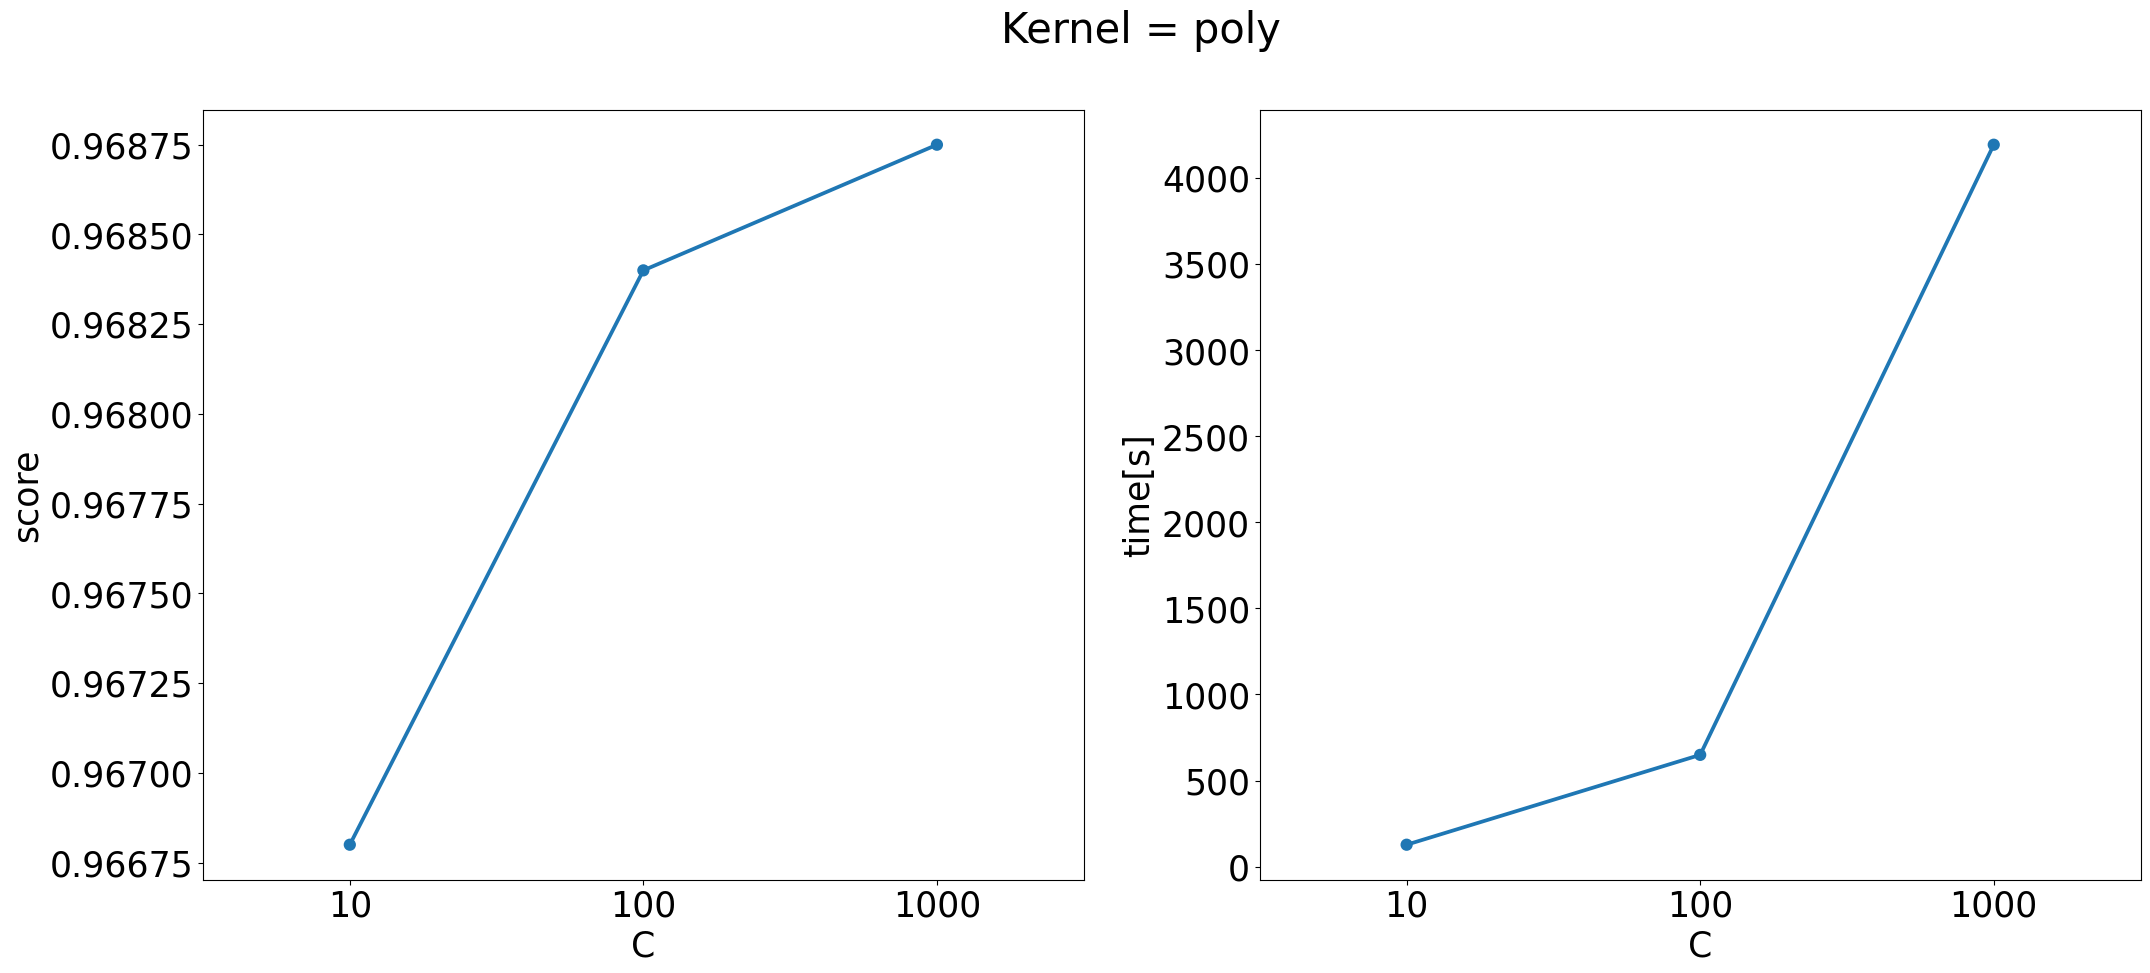

In [ ]:
plt.rcParams["font.size"] = 25

fig, axs = plt.subplots(1, 2, figsize=(25, 10))
fig.suptitle('Kernel = poly')

sns.pointplot(grid_poly_C, x='C', y='score', ax=axs[0], markers='o')

sns.pointplot(grid_poly_C, x='C', y='time[s]', ax=axs[1], markers='o')

plt.show()


### Aplicando parámetros óptimos - Round 3

In [ ]:
# popt = grid.best_params_
popt = {'C':1000, 'kernel':'poly', 'random_state':10}

In [ ]:
svm = SVC(**popt)
print(svm)
svm.fit(x_train_transformed, y_train)

train_predictions = svm.predict(x_train_transformed)
accuracy = accuracy_score(y_train, train_predictions)
print(f"\n\nAccuracy train {name}: %.3f%%" % (accuracy * 100.0))

val_predictions = svm.predict(x_val_transformed)
accuracy = accuracy_score(y_val, val_predictions)
print(f"Accuracy val {name}: %.3f%%" % (accuracy * 100.0))

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_val, val_predictions)
plt.show()

In [ ]:
print(classification_report(y_val,svm.predict(x_val_transformed)))

### Cross validation - Round 2

In [ ]:
FOLDS=5
cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=10)

x_train2 = np.array(x_train_transformed)
y_train2 = np.array(y_train)

svm = SVC(**popt)
print(svm)
avg_accuracy = 0
for fold, (train_idx, val_idx) in enumerate(cv.split(x_train2, y_train2)):
    xi, yi = x_train2[train_idx], y_train2[train_idx]
    x_valid, y_valid = x_train2[val_idx], y_train2[val_idx]
    svm = svm.fit(xi, yi)

    val_predictions = svm.predict(x_valid)
    accuracy = accuracy_score(y_valid, val_predictions)
    avg_accuracy +=accuracy
    print(f"Precisión val fold {fold}: {accuracy * 100.0 :.2f}" % ())

avg_accuracy /= FOLDS
print(f'\n\nAvg. accuracy = {avg_accuracy * 100}')

## Evaluación y guardado - Round 2 - C = 100 ; Kernel = 'poly' ; degree = 3

In [ ]:
test_pred = np.int64(svm.predict(x_test_transformed))

In [ ]:
submission = pd.DataFrame(list(zip(PatientId_test, test_pred)), columns=["patient", "diabetes"])
submission.to_csv("results/svm_poly_C-1000.csv", header=True, index=False)

NameError: name 'PatientId_test' is not defined